# Workshop -- Machine learning in life sciences
### What is it, when should it be used and how to avoid common pitfalls

**Author:** Benjamin Goudey, Research Fellow in Florey Department of Neuroscience and Mental Health at The University of Melbourne
**Last updated:** 04/6/2023

# Introduction
Welcome to the workshop! This notebook accompanies the workshop *Applying machine learning in life sciences: what does it mean and how to avoid common traps.*

The notebook focuses on the problem of predicting diabetes from a few clinical and blood measurements, as well as several "noise" variables.

The notebook is split into into four sections.

0. Welcome and setup
1. Exploring the data and fitting a model and measuring performance
2. Pitfall 1: Evaluation frameworks and generalisation
3.  Pitfall 2: Selecting features and model parameters

There will be a number of models, measures and algorithms that will be used and will be briefly explained in the accompanying tutorial but will not be covered in detail. The tidymodels documentation will be valuable here (https://www.tidymodels.org/find/all/)

The notebook assumes familiarity with R and tidyverse and a passing familiarity with the ggplot packages. But even if you don't have this, the idea is that this notebook should help you get an idea of some of the concepts around machine learning and may be a useful resource for you at some stage.

**Please note:** the expectation is you should be able to follow along rather than write this code from scratch. You should be able to run each cell in the notebook to get an output and then comments should direct you to indicate which parameters to change. If you get stuck, let us know!

## Section 0: Package loading and data set up
Don't worry too much about the code in this section. We load in the necessary packages and then there are a number of functions to load in the data or plot outputs. The details of these are mostly not needed for this workshop and I'll step through in more detail when they are needed.




In [109]:
# Google Colab set up
#
# Because we are using Google Colab, I've stored the environment that we need
# for this tutorial. This code downloads the environment and loads it again.
#
# Will take around 1 min to run.
download.file(url = "https://unimelbcloud-my.sharepoint.com/:u:/g/personal/ben_goudey_florey_edu_au/ETJBBKX7ji5PnQd989iWrC0BTwGxL6XjcXqO9NqIYNJduQ?download=1", destfile = 'IntroToMLEnv_20240611.zip')

unzip("IntroToMLEnv_20240611.zip", overwrite=T, exdir="/usr/local/lib/R")



In [2]:
#
# If you want to download this notebook and run it locally, run this cell instead
# of the first one.

#
#  if (!requireNamespace("rpart.plot", quietly = TRUE)) {
#    install.packages("rpart.plot")
#  }
#
#  # if the version of ggplot installed is less than 3.5, install a new version
#  # from github
#  if (as.numeric(gsub('^([0-9]\\.[0-9]).*', '\\1', packageVersion('ggplot2')))<3.5) {
#    remotes::install_github('tidyverse/ggplot2')
#  }
#
#  # If pROC, a packaage for ROC curves is not installed, install it.
#  if (!requireNamespace("pROC", quietly = TRUE)) {
#    remotes::install_github("xrobin/pROC")
#  }
#
#  # If DataExplorer, a packaage for summarising data frames, is not installed, install it.
#  if (!requireNamespace("DataExplorer", quietly = TRUE)) {
#    install.packages("DataExplorer")
#  }
#
#  # If tidymodels, the framework for machine learning, id not installed, install it.
#  if (!requireNamespace("tidymodels", quietly = TRUE)) {
#      install.packages("tidymodels")
#  }
#  install.packages(c("randomForest", "ranger", "glmnet"))
#}
#

In [22]:
# Load packages
#
library(rpart.plot)
library(tidyverse)
library(MASS)  # for mvnorm (multivariate normal data generation)
library(scales)  # for rescaling data'
library(remotes)
library(tidymodels)
library(DataExplorer)
library(pROC)
if (!requireNamespace("tableone", quietly = TRUE)) {
install.packages('tableone')
}
library(tableone)
## Read in a set of helper functions
# Normally you'd just hve these locally but because we are using Google Colab, I found it
# easier to read these in directly from github.
devtools::source_url('https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/helpers.R')
download.file(url ='https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/helpers.R',  destfile = 'helpers.R')

ℹ SHA-1 hash of file is ebca3f4cb22af0e47a63d177d70949ddb535c4a1



## 0.2 Data loading

In [4]:
# Read the dataset straight from github
set.seed(1)
diabetes_df_raw <- read.csv(url("https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/RC_health_data_n2000.csv")) %>% filter(!is.na(id))



# Session 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the tidymodels packages.

In particular, we aim to
 - understand the dataset, its variables and their relationship.
 - introduce DataExplorer and tidymodels packages.
 - demonstrate how to fit a linear regression using tidymodel and look at the outputs.

## Background: Dataset

We are using data from a large retrospective study by Chen et al (2018, https://bmjopen.bmj.com/content/8/9/e021768), examining the association of BMI and age with incident diabetes (i.e. the development of diabetes after the study began).

Participants were individuals who received a health check from 2010 to 2016 by the Rich Healthcare Group in China and were at least 20 years old, had no "extreme" BMI (<15 kg/m2 or >55 kg/m2) and met a bunch of other criteria.

We will be making use of two subsets taken from different sites (n=2000 and n=413) and pretending they are two different studies (though they of course are not). This is relatively small in the machine learning space but is pretty large for many clinical/bioinformatics analyses.


There are 17 measurements in the original study that we make use of here.


| Column Name              | Meaning                                   | Units                                    |
|--------------------------|-------------------------------------------|------------------------------------------|
| Age (y)                  | Age of the participant                    | Years                                    |
| Gender(1, male; 2, female)| Gender of the participant                | Categorical (1 = Male, 2 = Female)       |
| site                     | Study site/location                       | Categorical                              |
| height(cm)               | Height of the participant                 | Centimeters (cm)                         |
| weight(kg)               | Weight of the participant                 | Kilograms (kg)                           |
| z                        | Body Mass Index (unstandardized)          | Kilograms per Square Meter (kg/m²)       |
| SBP(mmHg)                | Systolic Blood Pressure                   | Millimeters of Mercury (mmHg)            |
| DBP(mmHg)                | Diastolic Blood Pressure                  | Millimeters of Mercury (mmHg)            |
| FPG (mmol/L)             | Fasting Plasma Glucose                    | Millimoles per Liter (mmol/L)            |
| Cholesterol(mmol/L)      | Total Cholesterol                         | Millimoles per Liter (mmol/L)            |
| Triglyceride(mmol/L)     | Triglycerides                             | Millimoles per Liter (mmol/L)            |
| HDL-c(mmol/L)            | High-Density Lipoprotein Cholesterol      | Millimoles per Liter (mmol/L)            |
| LDL(mmol/L)              | Low-Density Lipoprotein                   | Millimoles per Liter (mmol/L)            |
| ALT(U/L)                 | Alanine Aminotransferase                  | Units per Liter (U/L)                    |
| AST(U/L)                 | Aspartate Aminotransferase                | Units per Liter (U/L)                    |
| BUN(mmol/L)              | Blood Urea Nitrogen                       | Millimoles per Liter (mmol/L)            |
| CCR(umol/L)              | Creatinine Clearance Rate                 | Micromoles per Liter (umol/L)            |

Additionally, when loading in the data, we will be exploring the impact of randomly generated features that are not associated with your outcome. Such measurements are often generated in high-throughput 'omics studies where many things are measured that are not known to be associated.

### Analysis aim

The analysis goals from this dataset were "inference" based, i.e. trying to understand a relationship:

> We investigated the association between body mass index (BMI) and diabetes across a wide range of age groups.

For the purposes of this workshop, we'll assume the equivilnet predictive question **"does BMI improve prediction of incident dementia between 2 and 7 years from onset beyond age, sex, and blood glucose?"**. Now we have a specific baseline we can evaluate against.

For those who are interested, the full study is available at https://datadryad.org/stash/dataset/doi:10.5061/dryad.ft8750v



### 1.1 Basic data exploration

The first step in any modelling some **exploratory data analysis (EDA)** to get a feeling for the data that you will be exploring. This can help to identify variables that are highly skewed, have strong outlier or which have been recorded in an unexpected manner. They can also help give some expectations around the difficulty of the machine learning task that you want to explore.

While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream.

The DataExplorer package takes a data frame and gives a report that has a number of summary statistics of the variables in the dataset.


**Examine the following:**

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



In [6]:
# Load the data
diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=1000, add_n_features=10)

cat(sprintf("Number of individuals in training data: %s\n", nrow(diabetes_data[['study1']])))
cat(sprintf("Number of individuals in test data: %s\n", nrow(diabetes_data[['study2']])))

Number of individuals in training data: 1000
Number of individuals in test data: 413


This cell makes a "Table 1" style table summarising the data. I've found it may take a minute to run but gives a handy summary of the datasets.

In [7]:
# Create a Table 1, summarising the data across the two datasets
diabetes_studies_df <- rbind(diabetes_data[['study1']] %>% mutate(study=1),
                             diabetes_data[['study2']] %>% mutate(study=2)
                            )
# This function controls what table gets created. In particular, strata could be
# altered to "diabetes" to look at the relationship of variables with the outcome
#  of interest, rather than across the studies.
tab1 <- tableone::CreateTableOne(data = diabetes_studies_df, strata = "study" )
print(tab1, formatOptions = list(big.mark = ","))

                                    Stratified by study
                                     1              2              p      test
  n                                   1,000            413                    
  age_y (mean (SD))                   57.44 (12.88)  49.99 (12.00) <0.001     
  gender_1_male_2_female (mean (SD))   1.32 (0.47)    1.18 (0.39)  <0.001     
  height_cm (mean (SD))              165.42 (8.77)  167.47 (7.92)  <0.001     
  weight_kg (mean (SD))               69.24 (12.47)  70.28 (11.75)  0.147     
  bmi_kg_m2 (mean (SD))               25.20 (3.46)   24.96 (3.13)   0.240     
  sbp_mm_hg (mean (SD))              131.28 (19.54) 123.46 (15.75) <0.001     
  dbp_mm_hg (mean (SD))               79.87 (11.88)  77.91 (10.26)  0.003     
  fpg_mmol_l (mean (SD))               5.57 (0.73)    5.61 (0.63)   0.297     
  cholesterol_mmol_l (mean (SD))       4.97 (0.91)    4.97 (0.91)   0.971     
  triglyceride_mmol_l (mean (SD))      1.76 (1.21)    1.88 (1.38)   0.124  

These functions from the Data Explorer package make a few plots of the data. The histograms and correlations plots in particular are likely to be of interest.

***Note:*** To see all of the plots, you may need to scroll within the window below. To scroll the document again, scroll outside the cell to the left or right.

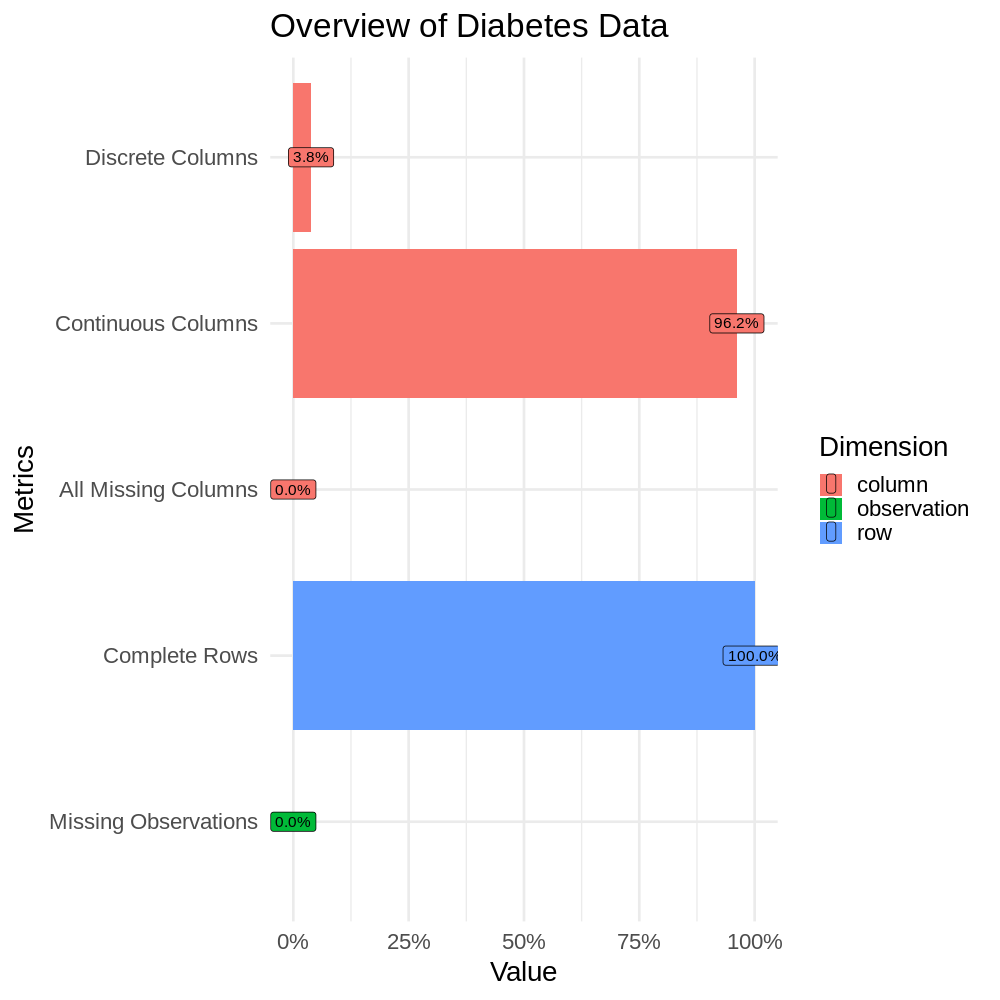

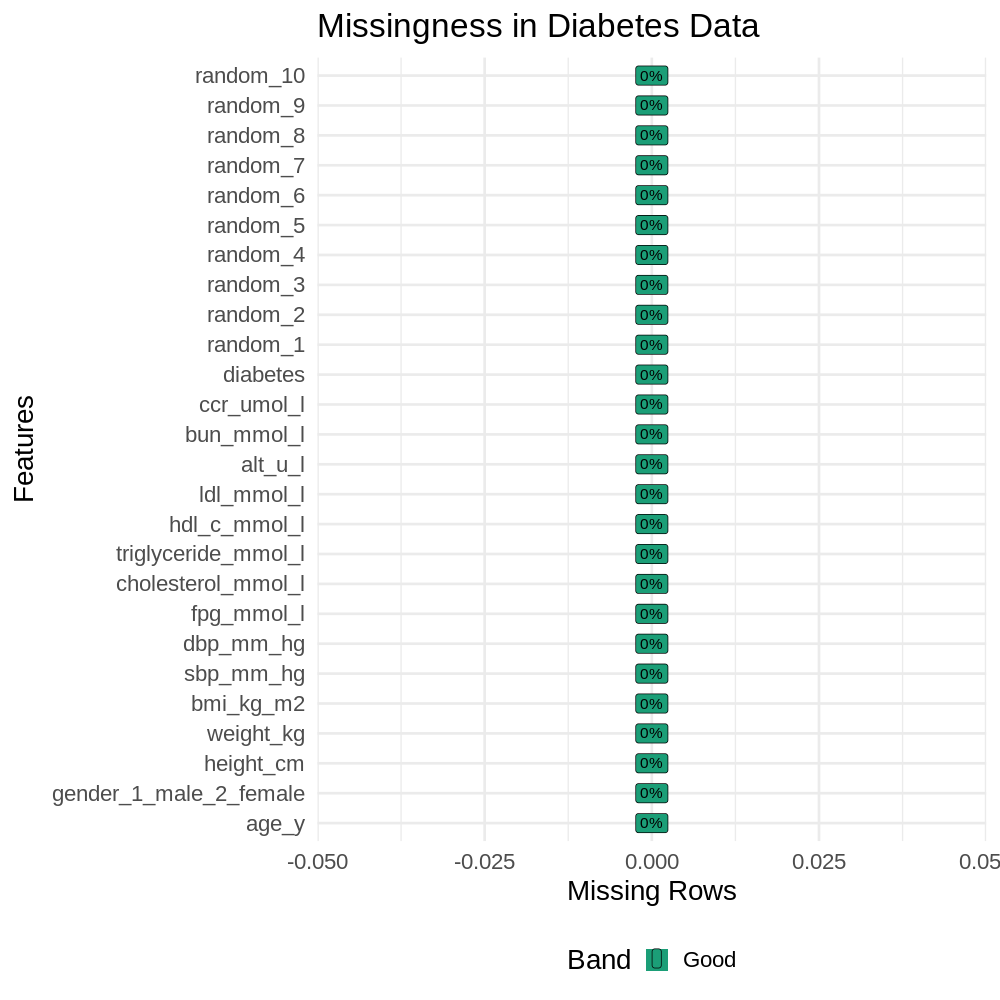

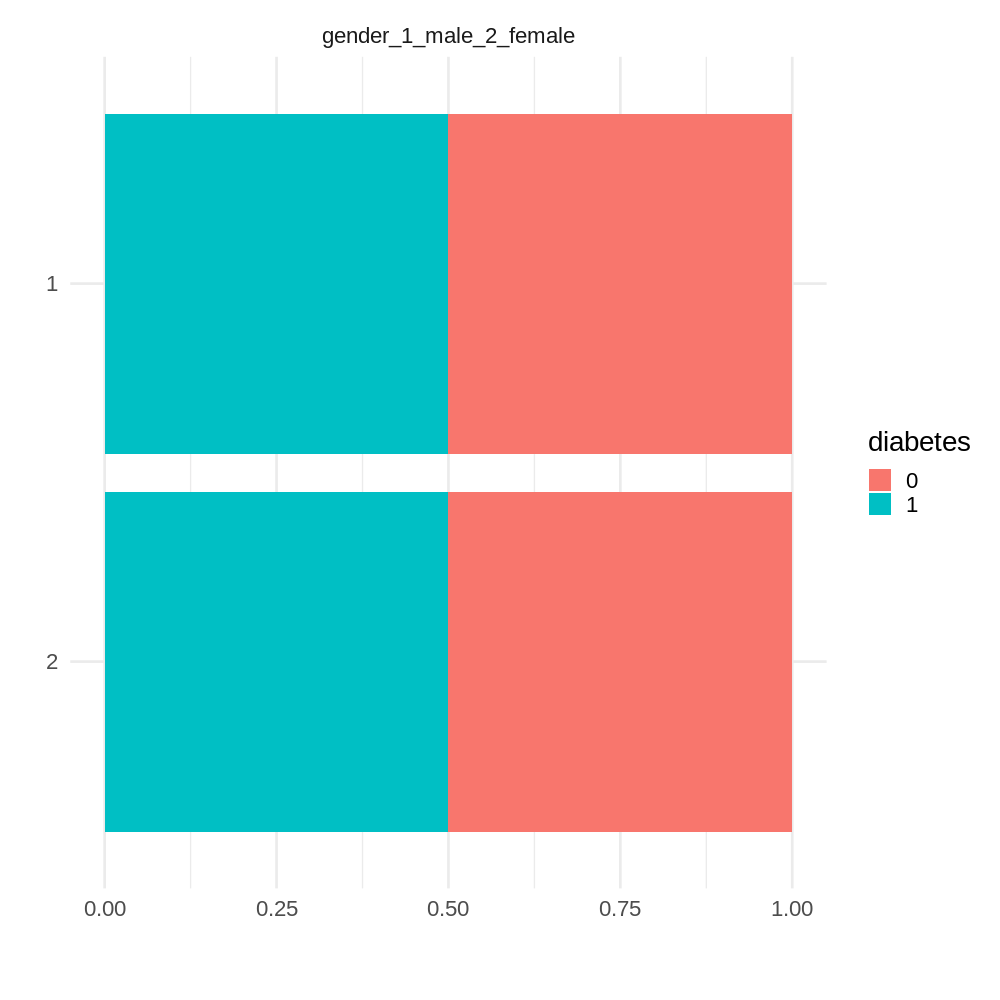

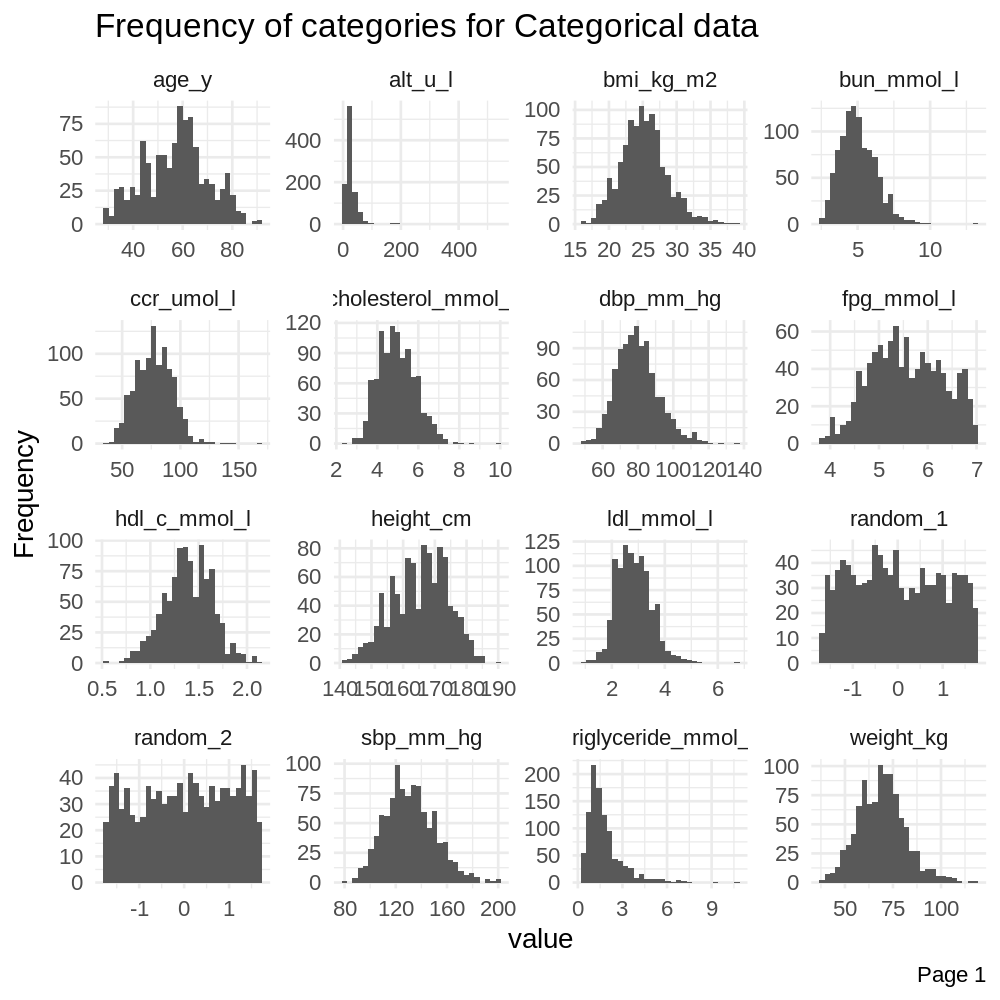

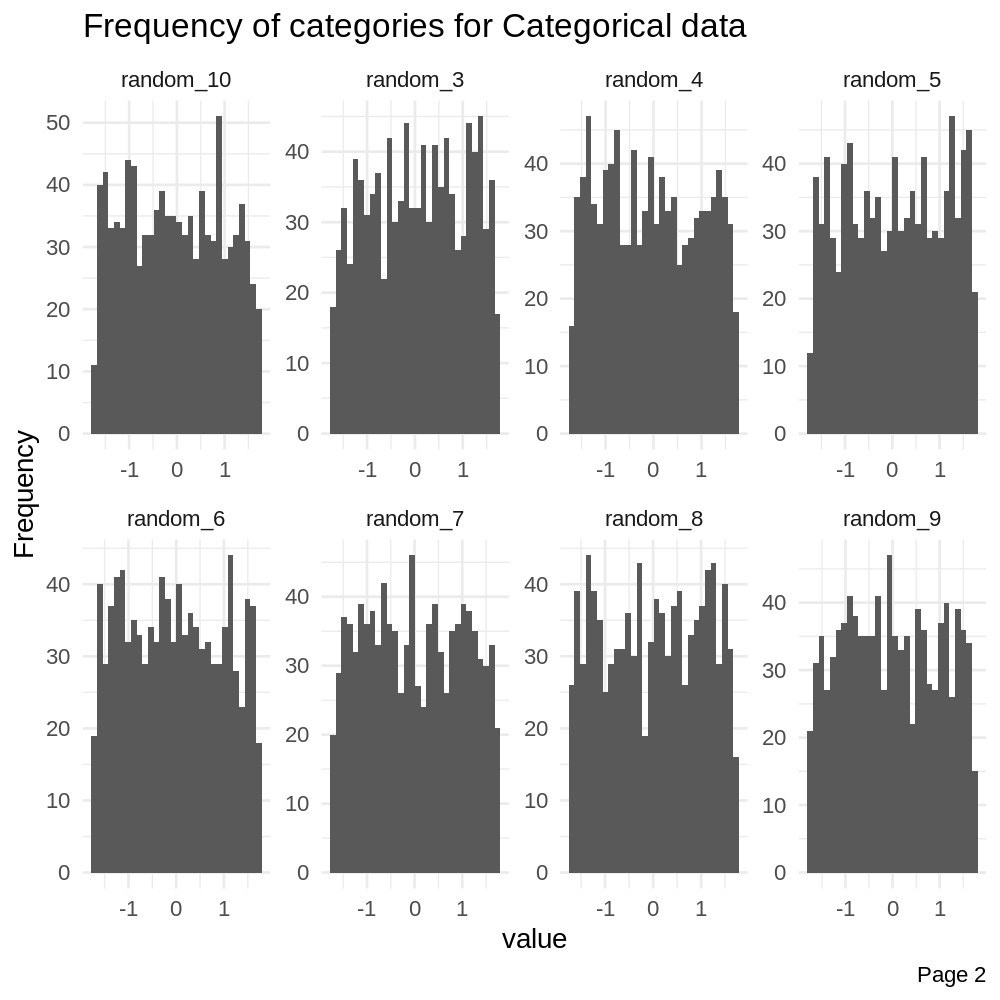

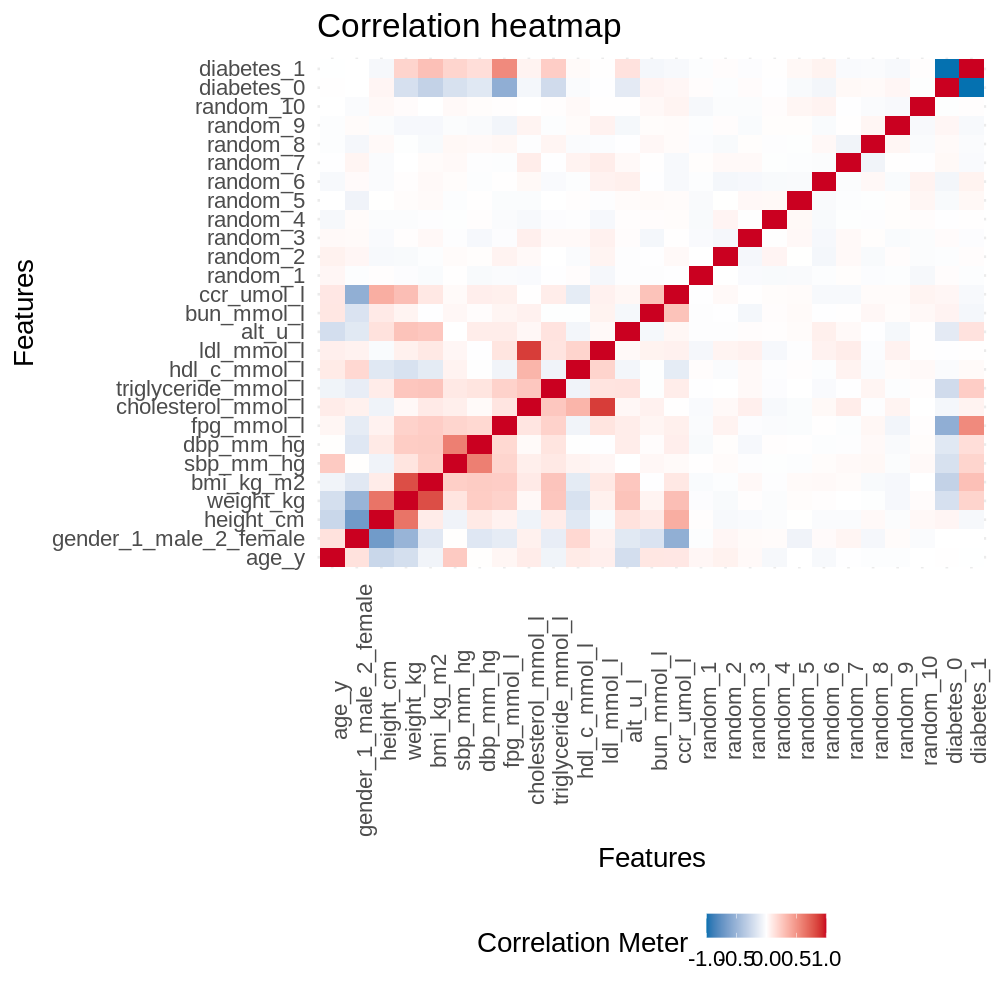

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
#DataExplorer::create_report(diabetes_train_df)
plot_intro(diabetes_data[['study1']],
           title = "Overview of Diabetes Data",
           ggtheme = theme_minimal(base_size = 20),
                )
plot_missing(diabetes_data[['study1']],
           title = "Missingness in Diabetes Data",
           ggtheme = theme_minimal(base_size = 20))

plot_bar(diabetes_data[['study1']], by="diabetes",
           ggtheme = theme_minimal(base_size = 20))

plot_histogram(diabetes_data[['study1']],
           title = "Frequency of categories for Categorical data",
           ggtheme = theme_minimal(base_size = 20))

plot_correlation(diabetes_data[['study1']], maxcat = 5L,
           title = "Correlation heatmap",
           ggtheme = theme_minimal(base_size = 20))

## 1.3 Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression using all of the measurements in the data by default.

Note that in tidymodels, the creation of a predictive model is broken down into several steps, each handled by a separate package

| Step | Package |
|------|---------|
| 1. Specifying the model | `parsnip` |
2. Specifying the model response, features and any transforms to the data | `recipes` |
3. Combining the model and data specification to fit the model | `workflow` |
4. Evaluating model performance | `yardstick` |



We begin by plotting the data, the model fit and some classic summary statistics.

### Questions:
 - Which features are the most predictive?
 - How much improvement to you get if you combined features compared to a model based on individual features?
 - Try regenerating the dataset with more or less noise. What happens to prediction accuracy as you add more noisy variables?

 Note: the data has a bunch of variables called noise_<number> e.g noise_1, noise_2 etc. These are just randomly generated numbers. But in real life these types of variables do exist - they are essentially any variable that is unrelated to the thing we are trying to predict. In this data, we explicitly know these noise variables but in your own datasets (and for the other variables in the diabetes dataset), we have no idea which variables are related and which are not.



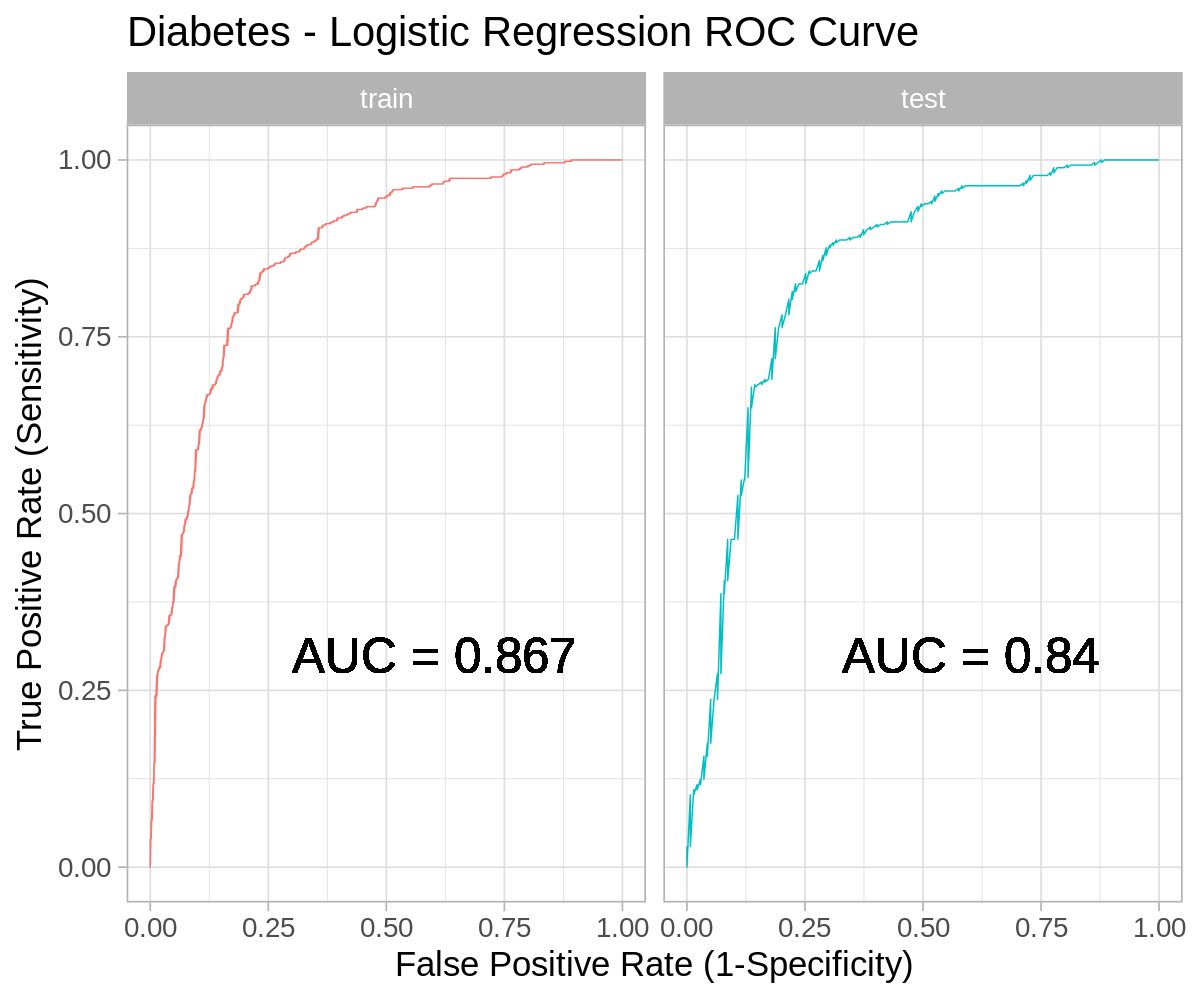

In [27]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 100)

#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

# Setting up the model specification via parsnip::logistic_reg
logit_spec <- logistic_reg(mode = "classification", penalty = 0, engine = "glm")

# Set up a recipe defining how you want the data to be transformed
# and defining the model response (diabetes) and features (everything else)
#
# Note the commented out part defining which variables to log transform.
#  feel free to add this back in.
diabetes_rec <-
  recipe(diabetes ~ ., data = diabetes_data[['study1']]) #%>%
  #step_log(alt_u_l, triglyceride_mmol_l) %>%
  #step_normalize(all_numeric_predictors())

# Note with the formula
# Any variable on the left-hand side of the tilde (~) is considered the model outcome (here, diabetes).
# On the right-hand side of the tilde are the predictors. Variables may be listed by name, or you can use the dot (.)
# to indicate all other variables as predictors.

# Setting up the workflow that combines model and preprocessing
workflow <- workflow() %>%
  add_recipe(diabetes_rec) %>%
  add_model(logit_spec)

# Fitting the model
model_fit <- workflow %>%
         fit(data = diabetes_data[['study1']])

# Make predictions
diabetes_train_preds <- predict(model_fit, diabetes_data[['study1']], type = "prob")
diabetes_test_preds  <- predict(model_fit, diabetes_data[['study2']], type = "prob")

# Pull out the actual labels
diabetes_train_labels <- diabetes_data[['study1']] %>% dplyr::select(diabetes)
diabetes_test_labels  <- diabetes_data[['study2']] %>% dplyr::select(diabetes)


# Now plot the ROC curves and their AUCs
plot_roc_auc(diabetes_train_preds, diabetes_test_preds,
             diabetes_train_labels, diabetes_test_labels,
             label="Diabetes - Logistic Regression")


## 1.4 Examine top features
Logistic regression provides an interpretable model. To see which features are most important, we can look at the coefficients of each variable. Larger absolute values implies more impact in the predictions.


### Examine the following:

1. Do any noise variables make it into the top 10?
2. What if you generate lots of noise variables (>1000)


In [28]:
model_fit$fit$fit$fit %>%
  tidy() %>%
  arrange(p.value) %>%
  mutate(rank=1:n()) %>%
  relocate(rank,1) %>%
  slice_head(n=10)

rank,term,estimate,std.error,statistic,p.value
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,fpg_mmol_l,2.12662758,0.15016202,14.162220,1.569555e-45
2,triglyceride_mmol_l,0.25189670,0.08679297,2.902271,3.704680e-03
3,hdl_c_mmol_l,1.08868957,0.39069483,2.786547,5.327287e-03
4,ldl_mmol_l,-0.78566910,0.28754203,-2.732363,6.288188e-03
5,sbp_mm_hg,0.01247439,0.00573614,2.174701,2.965254e-02
6,random_6,0.17792535,0.08428161,2.111082,3.476530e-02
7,bun_mmol_l,-0.14656280,0.07235723,-2.025545,4.281147e-02
8,height_cm,-0.13918725,0.07174937,-1.939909,5.239073e-02
9,random_5,0.15427277,0.08155184,1.891714,5.852906e-02



# Session 2: More models and metrics in `tidymodels`

In the previous example, we fit a logistic regression model to the given dataset and examine its performance using AUC. However, in many studies where we are looking to create a predictive model, we will be interested in creating multiple models based on different underlying algorithms and possibly evaluating them based on different criteria. Here, we demonstrate how these different models and metrics can be called and provide a few examples with our diabetes dataset as to the information you get.      

## 2.1 Exploring different models
Tidymodels has quite a standardised interface for fitting and applying different models. These standardised interfaces allow us to easily explore the impact of different classifiers for a problem. UNderstanding the different assumptions and methods is beyond this workshop. However, we can explore how this is done and talk through the impact of diffent classifiers.


**Examine the following:**

1. How well do different classifiers perform on the given dataset? Which models maximise performance on the training set? What does external performance look like?
2. Are there noticable timing differences?
3. Try the lasso and change the penalty from 0.1 to 0.01 or 1. Does it make a difference?

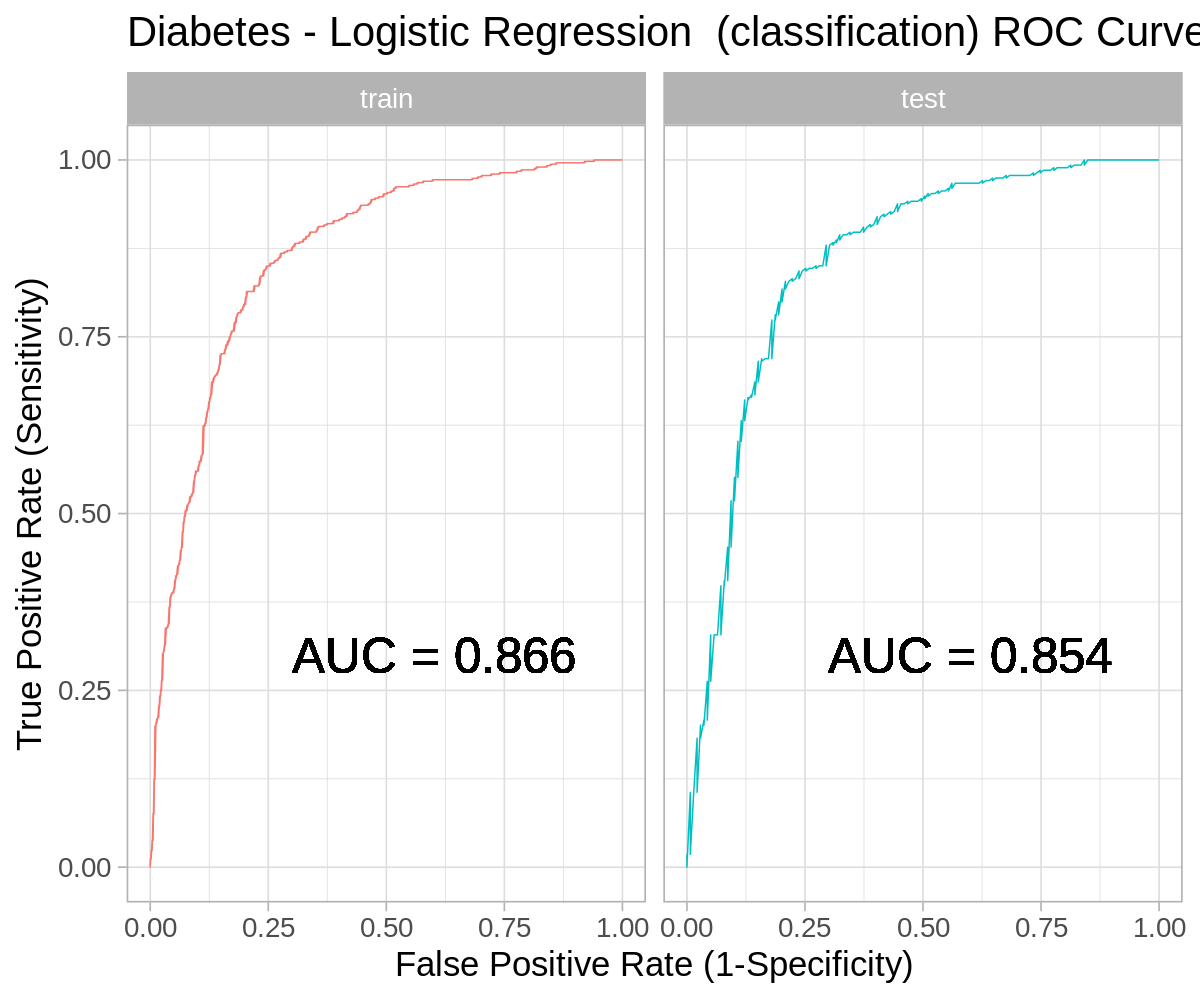

In [38]:
#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

# Define the models
models=list()
models[['log_reg']] = logistic_reg(mode = "classification", penalty = 0) %>%
                             set_engine("glm") %>%
                             set_mode("classification")

models[['lasso']] = logistic_reg(penalty = 0.1, mixture = 1) %>%
                             set_engine("glmnet") %>%
                             set_mode("classification")

models[['rf']] = rand_forest(mtry = 2, trees = 500, min_n = 3) %>%
                             set_engine("randomForest") %>%
                             set_mode("classification")

models[['decision_tree']]= decision_tree(tree_depth = 5) %>%
                             set_engine("rpart") %>%
                             set_mode("classification")

#---------

# Select the model of interest
current_model=models[["lasso"]]

# Fit the model
diabetes_rec <-
  recipe(diabetes ~ ., data = diabetes_data[['study1']]) %>%
  step_log(alt_u_l, triglyceride_mmol_l) %>%
  step_normalize(all_numeric_predictors())

# Setting up the workflow that combines model and preprocessing
workflow <- workflow() %>%
  add_recipe(diabetes_rec) %>%
  add_model(current_model)

# Fitting the model
model_fit <- workflow %>%
         fit(data = diabetes_data[['study1']])

# Make predictions
diabetes_train_preds <- predict(model_fit, diabetes_data[['study1']], type = "prob")
diabetes_test_preds  <- predict(model_fit, diabetes_data[['study2']], type = "prob")

# Pull out the actual labels
diabetes_train_labels <- diabetes_data[['study1']] %>% dplyr::select(diabetes)
diabetes_test_labels  <- diabetes_data[['study2']] %>% dplyr::select(diabetes)

# Some hacky way of getting a printable name
model_name = gsub("Model Specification","", capture.output(print(current_model)[[1]])[1])

# Now plot the ROC curves and their AUCs
plot_roc_auc(diabetes_train_preds, diabetes_test_preds,
             diabetes_train_labels, diabetes_test_labels,
             label=str_c("Diabetes - ", model_name))


## 2.2 Example of a specific model output
Different machine learning methods have very different underlying algorithms and can produce very different outputs.

Below we take an example at a unique output, that of a decision tree, to peek into how it works. Here, the model produces a sort of flowchart for how a sample should be classifier, based on a series of binary decisions. We visualise this model below where each node shows
1. A variable chosen to make a decision and a threshold for which side of the subtree we go down
2. gini value, a measure of how well the given split separates classes (lower is more discriminative)
3. samples is the number of samples in a node in the training data
4. values is the number of samples in each class in the training data (sum of 'values' is the same as 'samples')

**Examine the following:**
1. What happens when we have more or less noise variables in the data? Do they make it into the tree?
2. What if we make the tree bigger or smaller (n=1 or n=5)? How do you think the model will perform
3. Try make the max_depth=7. Is the tree still interpretable? How many noise variables are included

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”
Warning message:
“cex and tweak both specified, applying both”


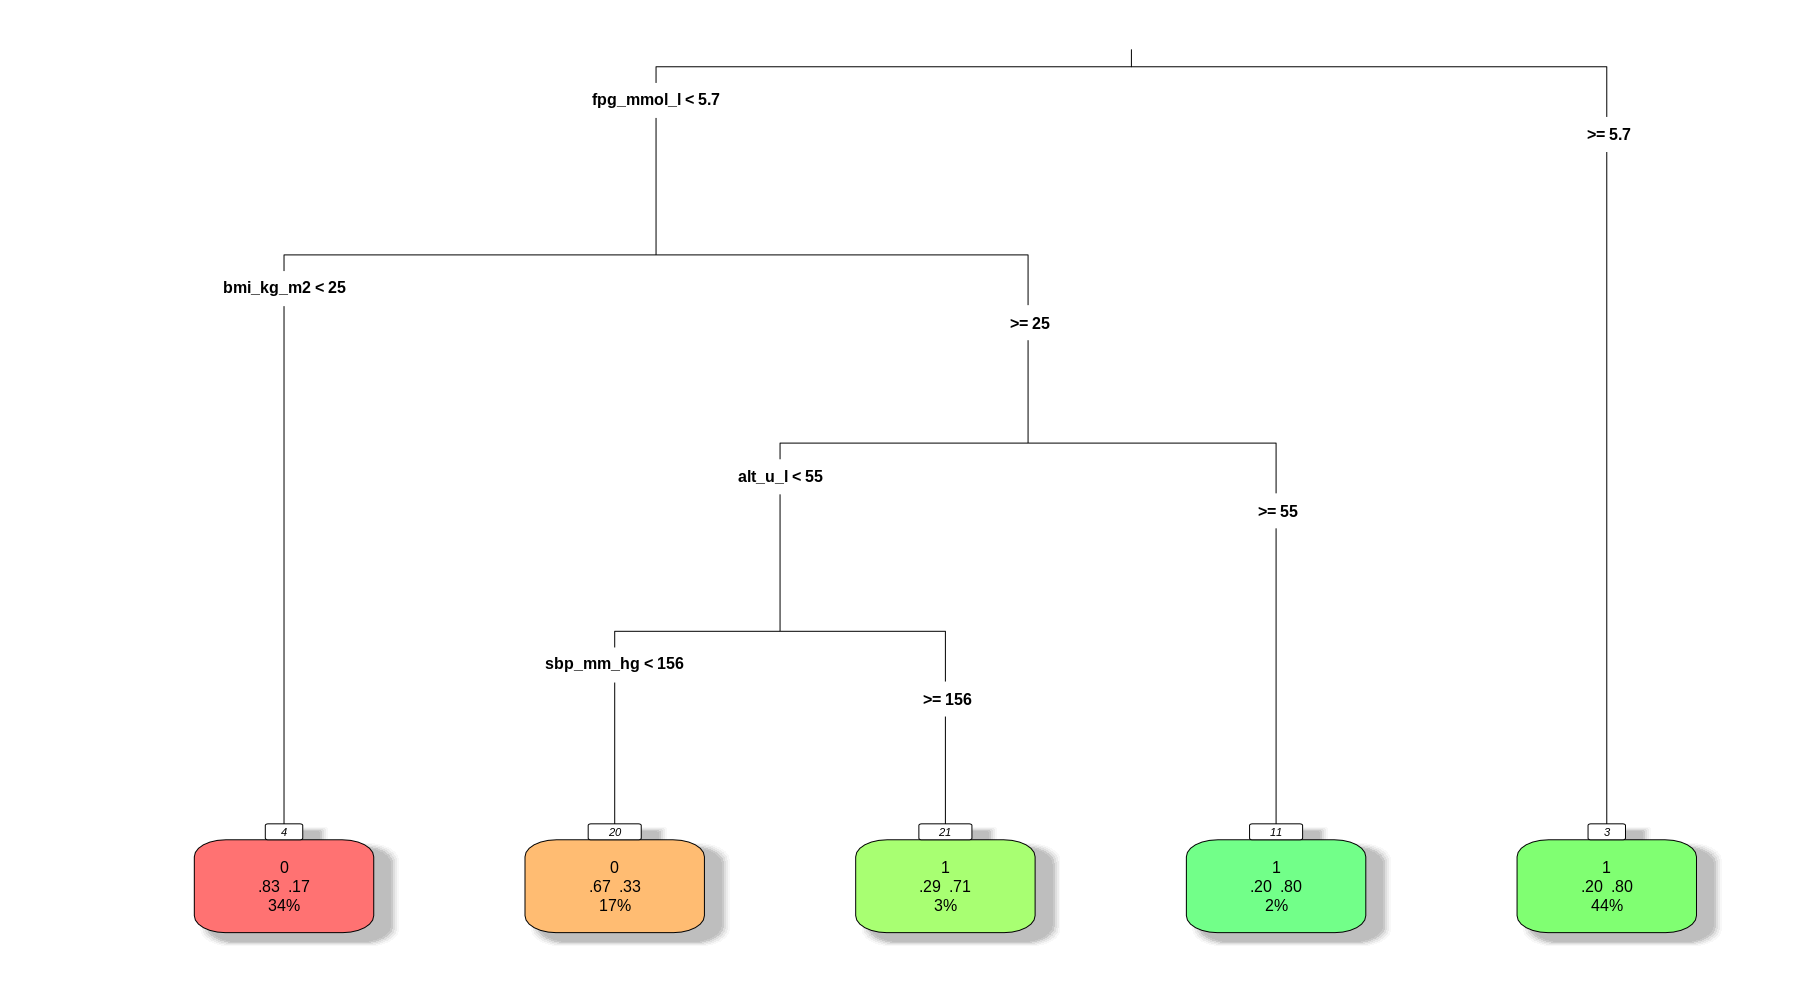

In [39]:
options(repr.plot.width = 18, repr.plot.height = 10, repr.plot.res = 100)

# Define the model
dt_model <- models[['decision_tree']]

# Fit the model
dt_fit <- dt_model %>%
  fit(diabetes ~ ., data = diabetes_data[['study1']], model=T)

# Plot the decision tree
rpart.plot(dt_fit$fit, type = 3, extra = 104, cex = 0.8, fallen.leaves = TRUE, tweak = 1.2,
           box.palette = "RdYlGn", shadow.col = "gray", nn = TRUE)

## 2.3 Exploring different metrics, models and preprocessing in combination

We can see from the previous cells that it can be difficult to keep track of model performance when running things one by one. Thanksfully, there is an extended version of workflows in the `workflow-sets` package, which allow you to pass in lists of models, metrics and preprocessing and get predictions for all combinations.

**Be aware** that this can become slow if you have a lot of things to explore

More details are at https://workflowsets.tidymodels.org/index.html

Examine the following:

1. Do different metrics ever change the ranking of which methods are best?
2. How do results compare on the internal and external predictions? Are they the same? Do they dramatically differ?
3. What happens when you adjust the amount of additional variables in the dataset?
4. Here, we add a baseline model with only age and fasting blood glucose at baseline. How well does it do?

In [108]:
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)

#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

train_test_split_rset <- df_to_rset(df1=diabetes_data[['study1']], df2=diabetes_data[['study2']])
metrics_dict <- metric_set(accuracy, bal_accuracy, roc_auc, mn_log_loss)


diabetes_recs = list(
  'all_feats_scaled'=
     recipe(diabetes ~ .,
     data = diabetes_data[['study1']]) %>%
     step_log(alt_u_l, triglyceride_mmol_l) %>%
     step_normalize(all_numeric_predictors()),
  'all_feats_unscaled'=
     recipe(diabetes ~ .,
     data = diabetes_data[['study1']]),
  'age_fpg_noscale'=
     recipe(diabetes ~ age_y + fpg_mmol_l ,
     data = diabetes_data[['study1']])
    )

# Take combinations of all preprocessing and all models
multi_model_workflow <-  workflow_set(
    preproc = diabetes_recs,
    models = models
  )

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = train_test_split_rset,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  collect_metrics(summarize=FALSE)

# Print the performance table
metrics %>%
  pivot_wider(id_cols=c(wflow_id,id),
  names_from = `.metric`, values_from = `.estimate` ) %>%
  filter(id!='Train:Dataset1, Test:Dataset2') %>%
  knitr::kable(digits=3, format='simple')

metrics %>%
  pivot_wider(id_cols=c(wflow_id,id), names_from = `.metric`, values_from = `.estimate` ) %>%
  filter(id=='Train:Dataset1, Test:Dataset2') %>%
  knitr::kable(digits=3, format='simple')



Timing stopped at: 1.942 0.197 2.141

Execution stopped; returning current results



ERROR: [1m[33mError[39m in `halt()`:[22m
[33m![39m There were 11 workflows that had no results.



# Session 3: Train/test and cross-validation frameworks

In the previous example, we built model on entire dataset and evaluated its performance on an exetrnal dataset. This is fine for very simple models but given the number of models, preprocessing options, hyperparameters and all of their combinations, it can become easy to overfit across datasets.

Moreover, there are many instances where all you have is a single dataset and no external dataset.

In both instances, the answer is to make use of cross validation.


Here, we will explore how cross-validation is implemented in tidyverse and its impact on our analysis. We'll also start to explore different models and how key parameters can be altered to change prediction performance.

## 3.1 Training and Test split

The following code examines training and testing a model on a single dataset and compares its performance to an external dataset in 3 scenarios:
 - Training on the entire dataset. Test on the same entire dataset.
 - Training on a proportion (default 80%). Test on the same proportion.
 - Training on a proportion (default 80%). Test on the remaining proportion.

**Questions:**
1. Run this cell a few times. Which accuracies change? Why?
2. Which evaluation scenario is closest to the external data performance?
2. What is the best performance you observe without changing parameters? What is the worst performance you observe?
3. What happens to test performance as you add a greater number of variables?
4. Try changing parameters ('C' for the l2 penalized logistic regression, or max_depth for Random Forest)

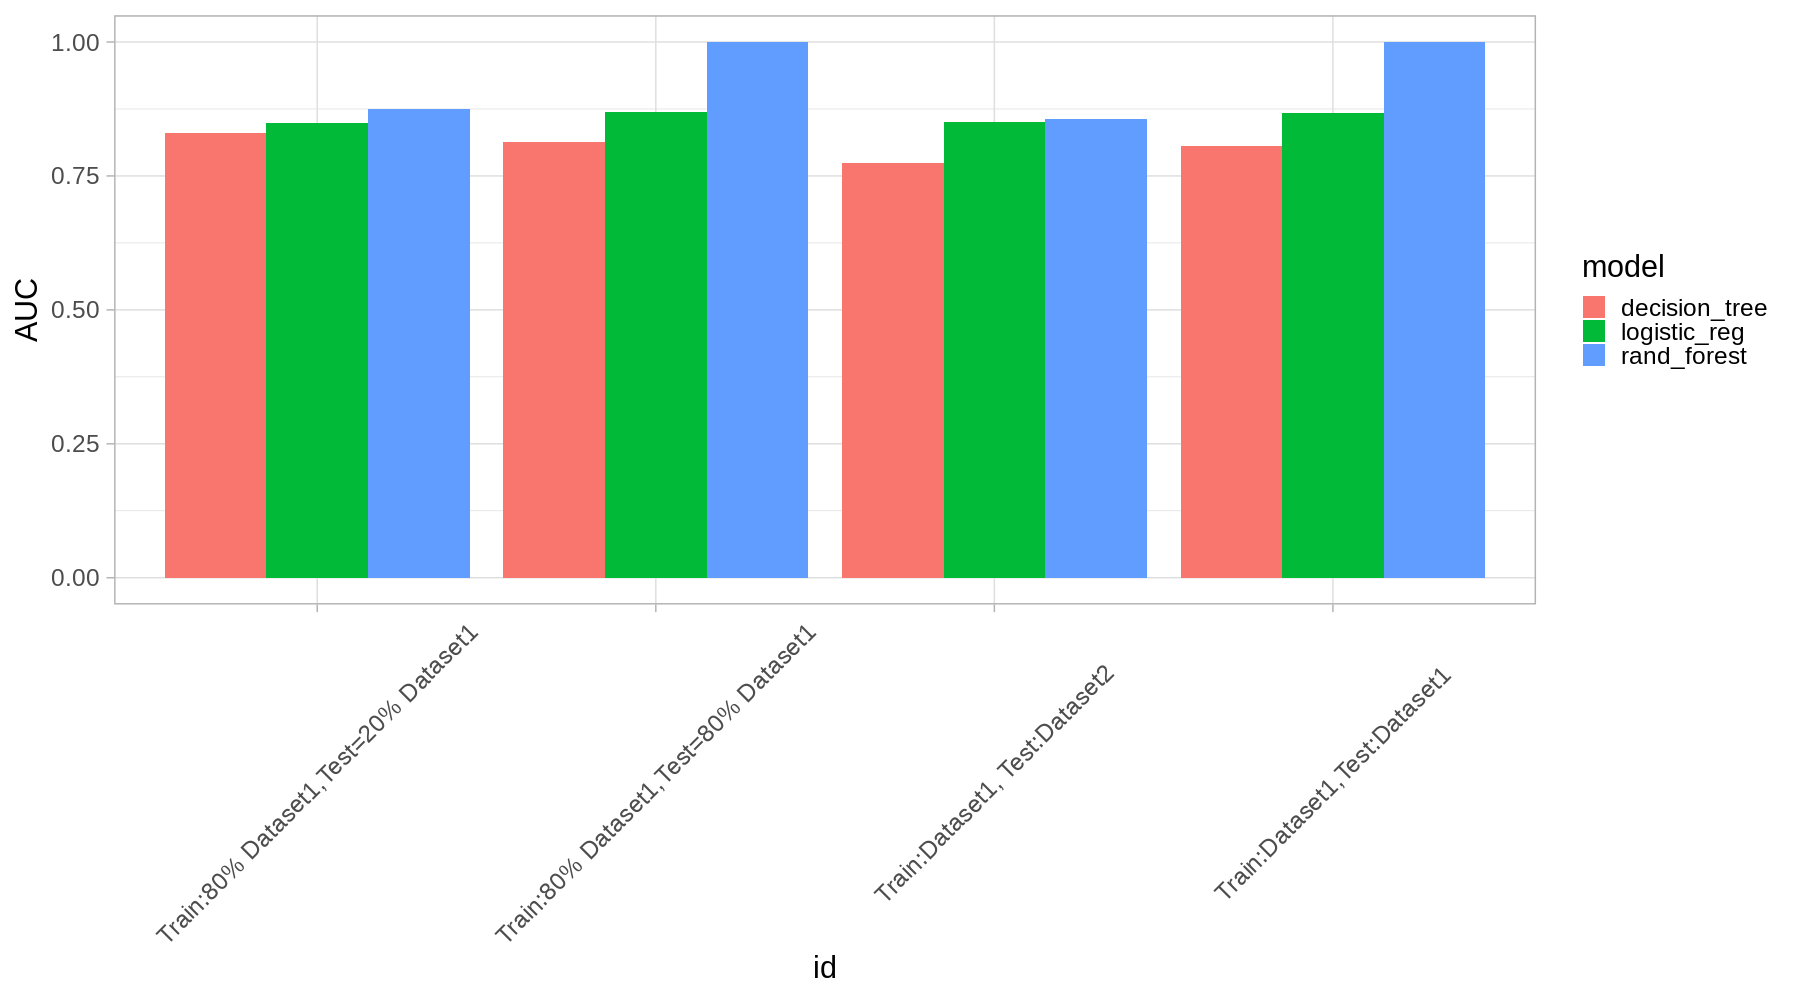

In [56]:
#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

# Setup three types of splits
# 1 Where we train on everything
# 2 Where we train on the trianing data and test on the training data
# 3 Where we train on the training data and test on the test data

# Split study 1 into 80% for training, 20% for testing
train_test_split=initial_split(diabetes_data[['study1']], prop = 0.8)
train_test_split_rset <- initial_split_to_rset(train_test_split, diabetes_data[['study1']], all=T, df2=diabetes_data[['study2']])

metrics_dict <- metric_set(roc_auc)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = models
  )

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = train_test_split_rset,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  tune::collect_metrics(summarize=FALSE)

metrics %>%
  ggplot(aes(x=id, y=.estimate, fill=model)) +
  geom_col(position='dodge') +
    theme_light(base_size=22) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5)) +
  ylab("AUC")




## 3.2 K-fold Cross-validation
Variability in the performance of different splits in the previous example motivates the use of K-fold cross validation. Here, we explore a few models and start to compare model performance.  

***Warning***: Be careful setting the values below. Setting the number of times to evaluate the classifiers too high and it will take too long to run for this workshop.

**Questions:**
1. Run this cell a few times. What is the range of the scores that are observed?
2. Which model is the best? How do you determine this?
3. Play around with hyperparameters, what is the impact on model performance? Which models are sensitive to these choices?


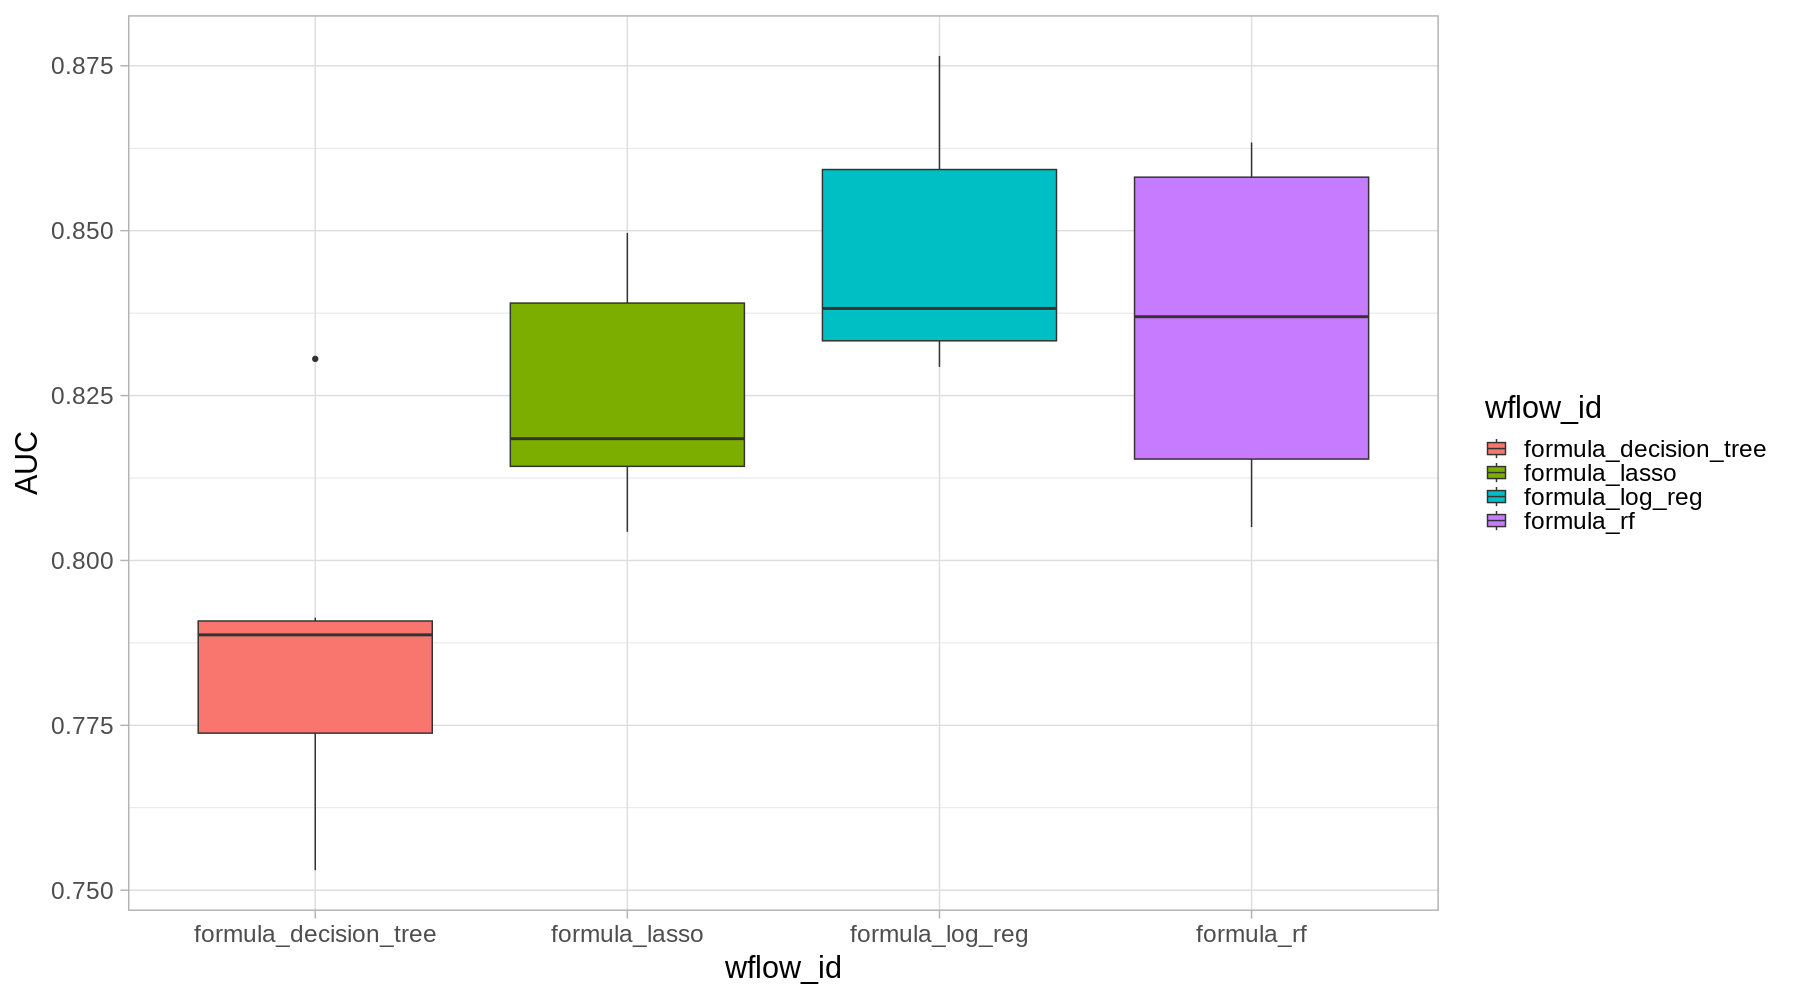

In [15]:
#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

# Define the models
models=list()
models[['log_reg']] = logistic_reg(mode = "classification", penalty = 0) %>%
                             set_engine("glm") %>%
                             set_mode("classification")

models[['lasso']] = logistic_reg(penalty = 0.1, mixture = 1) %>%
                             set_engine("glmnet") %>%
                             set_mode("classification")

models[['rf']] = rand_forest(mtry = 2, trees = 500, min_n = 3) %>%
                             set_engine("randomForest") %>%
                             set_mode("classification")

models[['decision_tree']]= decision_tree(tree_depth = 5) %>%
                             set_engine("rpart") %>%
                             set_mode("classification")

metrics_dict <- metric_set(roc_auc)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = models
  )

# K-fold cross-validation
kfold=vfold_cv(diabetes_data[['study1']], v = 3, repeats = 2)

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = kfold,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  tune::collect_metrics(summarize=FALSE)

metrics %>%
  ggplot(aes(x=wflow_id, y=.estimate, fill=wflow_id)) +
  geom_boxplot(position='dodge') +
  ylab("AUC") + theme_light(base_size=22)


# Session 4. Overfitting via feature selection and model parameters


## 4.1 Feature discrimination over entire dataset
One naive way to remove noise is to look at the features one-by-one,  look at their ability to discriminate the dataset and only take the most useful into our model. This is flawed but is common in the literature.

Lets take a look at the discriminatory ability of our features, here using significance from a logistic regression. We report the coefficient (as a measure of effect size) and p-value for each features.

**Question:**
1. How do measured and noise features compare?
2. What if we generate lots (n=10,000) noise features? How often can we distinguish noise and real signal?

In [86]:
#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)

feature_ranking <- sapply(setdiff(colnames(diabetes_data[['study1']]), 'diabetes'), \(nm) {
  res=coef(summary(glm(str_c('diabetes~',nm), family = 'binomial', data = diabetes_data[['study1']])));
  data.frame(feature=nm, beta=res[1,4], pvalue=res[2,4])},
simplify = F ) %>%
bind_rows() %>%
arrange(pvalue)

feature_ranking%>%
slice_head(n=10)

feature,beta,pvalue
<chr>,<dbl>,<dbl>
fpg_mmol_l,1.286422e-51,5.690358e-52
bmi_kg_m2,3.624571e-19,2.377842e-19
triglyceride_mmol_l,3.346547e-10,2.010200e-12
weight_kg,4.653585e-10,2.770021e-10
sbp_mm_hg,7.181222e-10,5.118348e-10
dbp_mm_hg,1.808727e-06,1.456785e-06
alt_u_l,1.320144e-04,1.121478e-05
random_6,9.585343e-01,6.385073e-02
cholesterol_mmol_l,8.450355e-02,7.952695e-02


## 4.2 Demonstrating potential overfitting when selecting features before CV
Given we've ranked the features in terms of their discrinatory ability, we could now select some top amount (based on p-value, f-statistic or a feeling for how many features we need).

But such an approach uses all of the information, and hence means there is no unsed data left for an untouched test set.

To explore this impact, the code below plots classifier performance starting with a single most discrinimatory feature and increasing to the top 32 features. We plot the model performance in training and testing.

Additionally, we plot the performance of constructing a model on all samples and evaluating the external dataset to show where the ideal would be.

**Questions**
1. What are the trends in the performance of the model on the training data as we increase features?
2. What are the trends in the performance of the model on the *test* data as we increase features?
3. Where is the ideal number of features for the external data?
4. How often does number of features to achieve the highest "test" performance correspond to the highest external performance?
5. What happens if you run this cell a few times? How do results differ? Why do they change?


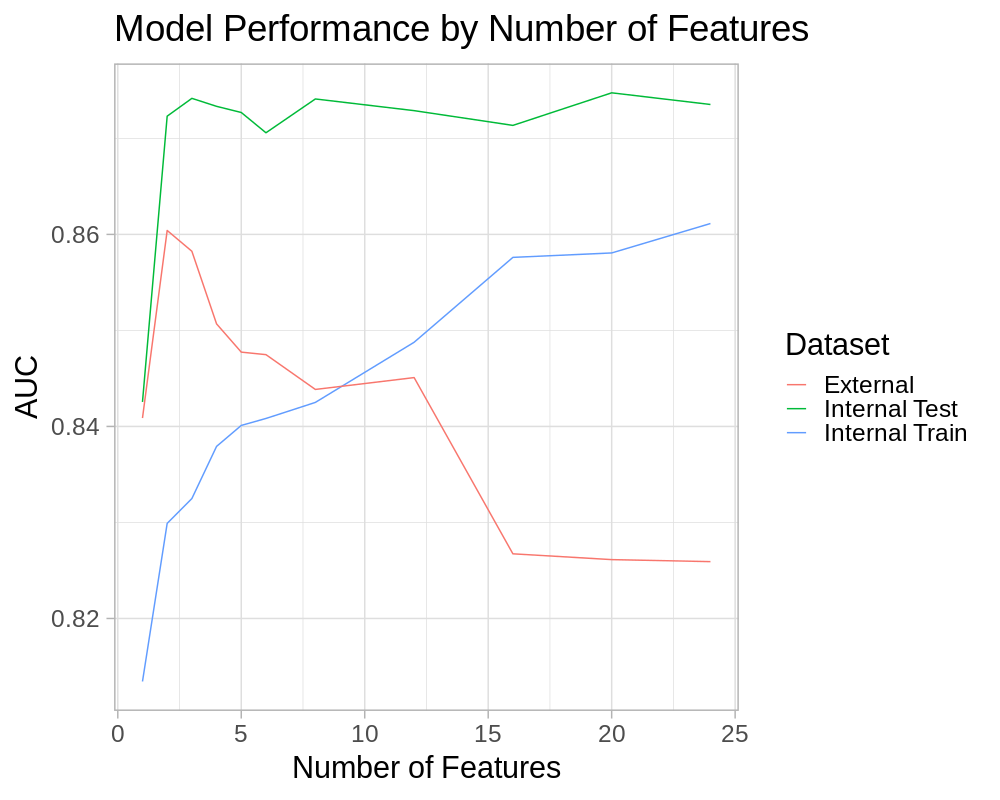

In [104]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)

# Define the number of features to use in models
n_feats <- c(1, 2, 3, 4, 5, 6, 8, 12, 16, 20, 24, 28, 32, 64, 128)
n_feats <- n_feats[n_feats <= nrow(feature_ranking)]

# Initialize lists to store results
auc_internal_train <- vector("list", length(n_feats))
auc_internal_test <- vector("list", length(n_feats))
auc_external <- vector("list", length(n_feats))

# Internal train/test split
set.seed(123)
split <- initial_split(diabetes_data[['study1']], prop = 0.75)
train_data <- training(split)
test_data <- testing(split)

for (i in seq_along(n_feats)) {
  top_features <- feature_ranking$feature[1:n_feats[i]]

  # Define the recipe with top features
  fm=as.formula(str_c("diabetes ~ ", paste(top_features, collapse="+")))
  diabetes_rec <- recipe(fm, data = diabetes_data[['study1']])

  # Define the model specification
  logit_spec <- logistic_reg(mode = "classification", penalty = 0, engine = "glm")

  # Define the workflow
  workflow <- workflow() %>%
    add_recipe(diabetes_rec) %>%
    add_model(logit_spec)

  # Fit the model
  model_fit <- workflow %>%
    fit(data = train_data)

  # Make predictions on internal test data
  internal_preds <- predict(model_fit, train_data, type = "prob")$.pred_1
  internal_labels <- train_data$diabetes
  auc_internal_train[[i]] <- roc(internal_labels, internal_preds, level=c(0,1), direction="<")$auc

  # Make predictions on internal test data
  internal_preds <- predict(model_fit, test_data, type = "prob")$.pred_1
  internal_labels <- test_data$diabetes
  auc_internal_test[[i]] <- roc(internal_labels, internal_preds, level=c(0,1), direction="<")$auc

  # Make predictions on external test data
  external_preds <- predict(model_fit, diabetes_data[['study2']], type = "prob")$.pred_1
  external_labels <- diabetes_data[['study2']]$diabetes
  auc_external[[i]] <- roc(external_labels, external_preds, level=c(0,1), direction="<")$auc
}

# Combine results into a data frame
results <- tibble(
  n_features = n_feats,
  auc_internal_train = unlist(auc_internal_train),
  auc_internal_test = unlist(auc_internal_test),
  auc_external = unlist(auc_external)
)
ggplot(results, aes(x = n_features)) +
  geom_line(aes(y = auc_internal_train, color = "Internal Train")) +
  geom_line(aes(y = auc_internal_test, color = "Internal Test")) +
  geom_line(aes(y = auc_external, color = "External")) +

  labs(title = "Model Performance by Number of Features",
       x = "Number of Features",
       y = "AUC",
       color = "Dataset") +
  theme_light(base_size=22)


## 4.3 Nested cross-validation for feature selection and hyperparameter tuning

Rather than selecting the number of features to be included in a model (based on a random guess, or worse peeking at test results), we can instead conduct feature selection as part of cross validation.

The code below runs two cross-validation loops (inner and outer), essentially running one loop on the training data (repeatededly breaking it into training and validation datasets) to understand how the number of features impacts performance. We then select the best number of features and evaluate the held-out testset. This is then repeated for the number of folds in the outer loop.

While robust, the approach can be computationally expensive as we are building many models.

**Warning** This code will take a few minutes. If you add in hyperparameter selection (by uncommenting param_grid),  this could take quite a while to run in Google Colab.

**Questions:**
1. Try generating a dataset with no noisy features and one with many? How much does performance vary?
2. How does performance vary if we change from a penalized regression to a random forest?

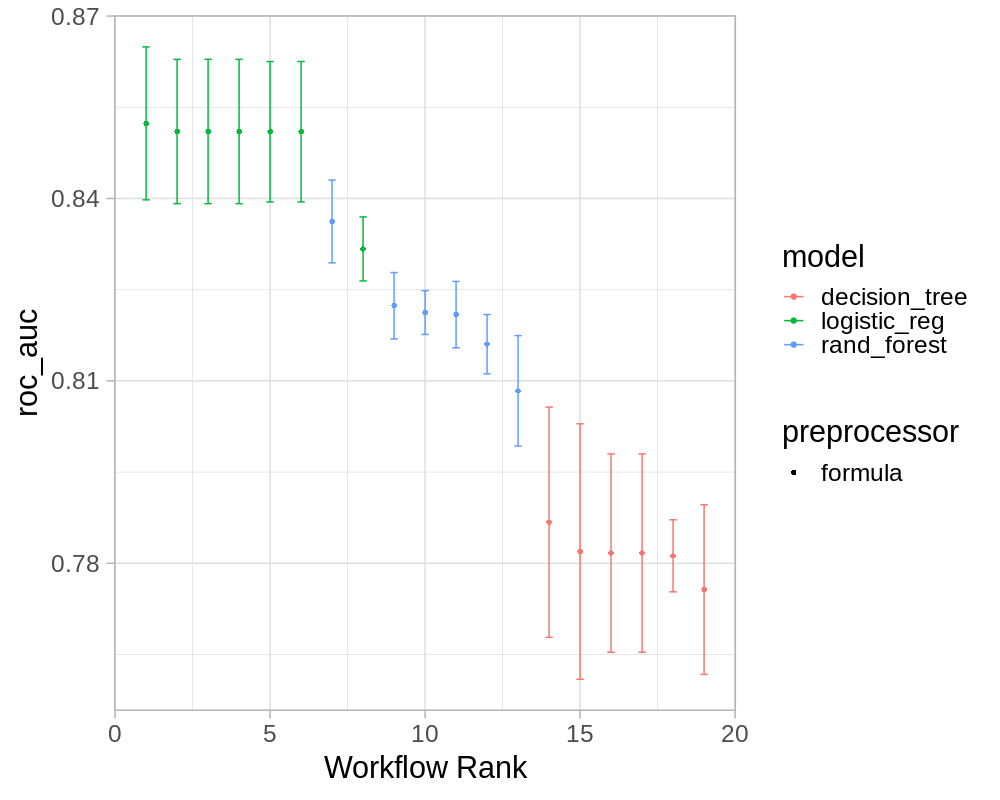

In [106]:
#diabetes_data <- load_diabetes_data(diabetes_df_raw, nsamples=400, add_n_features=10)
metrics_dict <- metric_set(accuracy, bal_accuracy, roc_auc, mn_log_loss)

# Define models with some parameters for tuning
models_tuned <- list()
models_tuned[['log_reg_tune']] <- logistic_reg(mode = "classification") %>%
  set_engine("glm")

models_tuned[['lasso_tune']] <- logistic_reg(mode = "classification",penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

models_tuned[['rf_tune']] <- rand_forest(mode = "classification",mtry = 1, trees = 500, min_n = tune()) %>%
  set_engine("randomForest")

models_tuned[['decision_tree_tune']] <- decision_tree(mode = "classification",tree_depth = tune()) %>%
  set_engine("rpart")


# Define the tuning grids
log_reg_grid <- grid_regular(penalty(), levels = 10)
lasso_grid <- grid_regular(penalty(), levels = 10)

#d cross-validation
kfold <- vfold_cv(diabetes_data[['study1']], v = 3, repeats = 2)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = c(models,models_tuned)
  )
# Fit models with tuning and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "tune_grid",
    resamples = kfold,
    grid = 5,
    metrics = metrics_dict,
    control = control_grid(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
 tune::collect_metrics(summarize = T)

autoplot(results, metric = "roc_auc") + theme_light(base_size=22)


#autoplot(results, metric = "roc_auc", id = 'log_reg') + theme_light(base_size=15)

## Final task
Using the above code, can you implement a scheme to answer the question "does BMI improve prediction of incident dementia between 2 and 7 years from onset beyond age, sex, and blood glucose?".

Steps:
 - Copy the code in the previous section
 - Add call to a model with a specified feature subset (as in section Cell 1.3)
 - Compare boxplots from these two models